# Grandes cidades brasileiras são progressistas?

In [1]:
import pandas as pd
import six
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
import seaborn as sns
import itertools
import geopandas as gpd

from pandas.plotting import table 
from IPython.display import HTML
from unidecode import unidecode

%matplotlib inline

# Ler repositório de votação do TSE (1996-2018)

Dados compilados pelo Brasil.io: https://brasil.io/dataset/eleicoes-brasil/votacoes/

In [2]:
cols = ['ano_eleicao', 'descricao_totalizacao_turno', 
        'codigo_municipio', 'nome_municipio', 'sigla_uf', 'nome_partido', 'numero_partido', 
        'sigla_partido', 'descricao_cargo', 'nome', 'numero_urna', 'numero_zona', 'total_votos']

df_chunk = pd.read_csv('input/2019-04-08/votacao-zona.csv', sep=',', usecols=cols, encoding='latin1', chunksize=1000000)

In [3]:
chunk_list = []

for chunk in df_chunk:  
    chunk_filter = chunk[chunk.descricao_cargo == 'PREFEITO']
    chunk_filter = chunk_filter[chunk_filter.descricao_totalizacao_turno.isin(['ELEITO', 'ELEITO POR QP', 'ELEITO POR MEDIA'])]
    chunk_filter.drop(['descricao_totalizacao_turno', 'descricao_cargo'], axis=1, inplace=True)
    chunk_list.append(chunk_filter)    
df_concat = pd.concat(chunk_list)

C:\Users\guilh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Dados parciais 2020

In [92]:
cols = ['codtse','ncand','nome','partido','votabs','situacao','uf']
df_2020 = pd.read_csv('input/prefeitos2020.csv', sep=';', usecols=cols)

In [93]:
df_2020 = df_2020[df_2020.situacao == 'Eleito']
df_2020.drop('situacao', axis=1, inplace=True)
df_2020.columns = ['codigo_municipio', 'numero_urna', 'nome', 'sigla_partido', 'total_votos', 'sigla_uf']

Criar colunas para satisfazer dataset principal

In [94]:
df_2020['ano_eleicao'] = 2020
df_2020['numero_partido'] = df_2020['numero_urna']
df_2020['numero_zona'] = 0

In [95]:
df_temp = pd.read_excel('input/tse_partidos.xlsx')
dict_partidos = pd.Series(df_temp.NOME.values, index = df_temp.LEGENDA.values).to_dict()
df_2020['nome_partido'] = df_2020.numero_partido.map(dict_partidos)

In [96]:
dict_sigla_partidos = pd.Series(df_temp.SIGLA.values, index = df_temp.LEGENDA.values).to_dict()
df_2020['sigla_partido'] = df_2020.numero_partido.map(dict_sigla_partidos)

In [97]:
df_temp = df_concat[['codigo_municipio', 'nome_municipio']].drop_duplicates('codigo_municipio', keep='first').sort_values('codigo_municipio')
dict_municipios = pd.Series(df_temp.nome_municipio.values, index = df_temp.codigo_municipio.values).to_dict()
df_2020['nome_municipio'] = df_2020.codigo_municipio.map(dict_municipios)

Agrupar zonas eleitorais

In [98]:
df = df_concat.append(df_2020, sort=False)
df = df.groupby(['ano_eleicao','codigo_municipio','numero_urna',
                 'nome_municipio','sigla_uf','nome_partido','numero_partido','sigla_partido'])['total_votos'].sum().reset_index()

# Filtrar por ano da eleição

In [99]:
ano_da_eleicao = df.ano_eleicao.unique().tolist()[1:]

Renomear partidos antigos

In [100]:
df.sigla_partido.replace('PRN','PTC', inplace=True)
df.sigla_partido.replace('PPB','PP', inplace=True)
df.sigla_partido.replace('PFL','DEM', inplace=True)
df.sigla_partido.replace('PTN','PODE', inplace=True)
df.sigla_partido.replace('PT DO B','AVT', inplace=True)
df.sigla_partido.replace('PEN','PATRI', inplace=True)
df.sigla_partido.replace('PMDB','MDB', inplace=True)
df.sigla_partido.replace('PSDC','DC', inplace=True)
df.sigla_partido.replace('PPS','CDD', inplace=True)
df.sigla_partido.replace('PR','PL', inplace=True)

# Mapa ideológico dos partidos

In [101]:
mapa_ideologico = {'PCB':'Esquerda',
                    'PT':'Esquerda',
                    'UP':'Esquerda',
                    'PSOL':'Esquerda',
                    'PSTU':'Esquerda',
                    'PC DO B':'Esquerda',
                    'PCO':'Esquerda',
                    'PDT':'Esquerda',
                    'REDE':'Esquerda',
                    'PSB':'Esquerda',
                    'PV':'Esquerda',
                    'SD':'Centro',
                    'PROS':'Centro',
                    'PTB':'Centro',
                    'PRB':'Centro',
                    'PP':'Centro',
                    'PMN':'Centro',
                    'PMB':'Centro',
                    'MDB':'Centro',
                    'PSDB':'Centro',
                    'CDD':'Centro',
                    'PSD':'Centro',
                    'DEM':'Direita',
                    'PL':'Direita',
                    'DC':'Direita',
                    'AVT':'Direita',
                    'PSC':'Direita',
                    'PODE':'Direita',
                    'PATRI':'Direita',
                    'NOVO':'Direita',
                    'PRTB':'Direita',
                    'PSL':'Direita',
                    'PTC':'Direita',
                    'PGT':'Esquerda',
                    'PST':'Esquerda',
                    'PHS':'Direita',
                    'PRP':'Direita',
                    'PPL':'Esquerda',
                    'PAN':'Centro',
                    'PRONA':'Direita'}

In [102]:
df['ideologia'] = df.sigla_partido.map(mapa_ideologico)

# Lista de população, tamanho e densidade por município

In [103]:
sigla_estado = {'AC':'Acre',
                'AL':'Alagoas',
                'AP':'Amapa',
                'AM':'Amazonas',
                'BA':'Bahia',
                'CE':'Ceara',
                'DF':'Distrito Federal',
                'ES':'Espirito Santo',
                'GO':'Goias',
                'MA':'Maranhao',
                'MT':'Mato Grosso',
                'MS':'Mato Grosso do Sul',
                'MG':'Minas Gerais',
                'PA':'Para',
                'PB':'Paraiba',
                'PR':'Parana',
                'PE':'Pernambuco',
                'PI':'Piaui',
                'RJ':'Rio de Janeiro',
                'RN':'Rio Grande do Norte',
                'RS':'Rio Grande do Sul',
                'RO':'Rondonia',
                'RR':'Roraima',
                'SC':'Santa Catarina',
                'SP':'Sao Paulo',
                'SE':'Sergipe',
                'TO':'Tocantins'}

In [104]:
capitais = {'AC':'Rio Branco',
            'AL':'Maceio',
            'AP':'Macapa',
            'AM':'Manaus',
            'BA':'Salvador',
            'CE':'Fortaleza',
            'DF':'Brasilia',
            'ES':'Vitoria',
            'GO':'Goiania',
            'MA':'São Luis',
            'MT':'Cuiaba',
            'MS':'Campo Grande',
            'MG':'Belo Horizonte',
            'PA':'Belem',
            'PB':'Joao Pessoa',
            'PR':'Curitiba',
            'PE':'Recife',
            'PI':'Teresina',
            'RJ':'Rio de Janeiro',
            'RN':'Natal',
            'RS':'Porto Alegre',
            'RO':'Porto Velho',
            'RR':'Boa Vista',
            'SC':'Florianopolis',
            'SP':'Sao Paulo',
            'SE':'Aracaju',
            'TO':'Palmas'}

In [105]:
regioes = {'Norte':['AC','AP','AM','PA','RO','RR','TO'],
           'Nordente':['AL','BA','CE','MA','PB','PE','PI','RN','SE'],
           'Centro-Oeste':['GO','MT','MS'],
           'Sudeste':['ES','MG','RJ','SP'],
           'Sul':['PR','SC','RN']}

Obter lista da população, tamanho e densidade por município

In [106]:
url = 'https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_do_Brasil_por_popula%C3%A7%C3%A3o_(2020)'
municipio_pop = pd.read_html(url, thousands=' ')[0]

# eliminar espaço para converter para int
municipio_pop['População'] = municipio_pop['População'].str.replace('\D', '').astype(int)

# converter estado e municipio para sem acentos e maiusculo
municipio_pop['Unidade federativa'] = municipio_pop['Unidade federativa'].str.upper().apply(lambda x: unidecode(x))
municipio_pop['Município'] = municipio_pop['Município'].str.upper().apply(lambda x: unidecode(x))

# abreviar UF
municipio_pop['sigla_uf'] = municipio_pop['Unidade federativa'].str.upper().apply(lambda x: [k for k, v in sigla_estado.items() if (unidecode(v.upper()) == x)])
municipio_pop = municipio_pop.explode('sigla_uf')

municipio_pop.drop('Posição', axis=1, inplace=True)
municipio_pop.set_index('Código IBGE', inplace=True)

In [107]:
url = 'https://pt.m.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_brasileiros_por_%C3%A1rea_decrescente'
municipio_km = pd.read_html(url, thousands=' ')[0]

municipio_km['Área (km²)'] = municipio_km['Área (km²)'].str.replace(',','.').str.replace(u'\xa0', u'').astype(float)
municipio_km.drop(['Posição','Município', 'Unidade federativa'], axis=1, inplace=True)
municipio_km.rename(columns={'Código do IBGE':'Código IBGE'}, inplace=True)
municipio_km.set_index('Código IBGE', inplace=True)

In [108]:
density_label = ['0-5','5-10','10-20','20-50','50-100','100-200','200-20k']

def agrupar_por_densidade(den):
    if den >= 0 and den < 5:
        return 0
    elif den >= 5 and den < 10:
        return 1
    elif den >= 10 and den < 20:
        return 2
    elif den >= 20 and den < 50:
        return 3
    elif den >= 50 and den < 100:
        return 4
    elif den >= 100 and den < 200:
        return 5
    elif den >= 200 and den < 20000:
        return 6
    else:
        return 'other'

In [109]:
municipios = pd.merge(municipio_pop, municipio_km, on='Código IBGE')
municipios['densidade'] = municipios['População'] / municipios['Área (km²)']

In [110]:
municipios['grupo_densidade'] = municipios.apply(lambda x : agrupar_por_densidade(x.densidade), axis=1)

In [111]:
# Obter tabela de correspondencia entre codigo de municipio do IBGE e TSE
link = 'https://raw.githubusercontent.com/estadao/como-votou-sua-vizinhanca/master/data/votos/correspondencia-tse-ibge.csv'
df_equivalencia = pd.read_csv(link)
df_equivalencia.set_index('COD_TSE', drop=False, inplace=True)
df_equivalencia.drop(['chave','NOME','UF'], axis=1, inplace=True)

In [112]:
df.set_index('codigo_municipio', drop=False, inplace=True)
df = df.join(df_equivalencia)

In [113]:
df.set_index('GEOCOD_IBGE', drop=False, inplace=True)
df = df.join(municipios[['População','densidade','grupo_densidade']])

Latitude e Longitude

In [114]:
# Obter tabela latitude e longitude para municipios
link = 'https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/main/csv/municipios.csv'
df_lat_long = pd.read_csv(link)
df_lat_long.set_index('codigo_ibge', inplace=True)
df_lat_long.drop(['nome','capital','codigo_uf'], axis=1, inplace=True)

In [115]:
df = df.join(df_lat_long)

# Funções auxiliares

In [28]:
def group_by_density(df, ideology=False):
    res = pd.DataFrame()
    for i, val in enumerate(ano_da_eleicao):
        # Filtrar pelo ano e remover municipios duplicados
        df_by_year = df[df.ano_eleicao == val].drop_duplicates(subset='codigo_municipio', keep='first')

        # Agrupar municipios eleitos por partido
        df_temp = df_by_year.groupby('sigla_partido').count().sort_values('codigo_municipio', ascending=False).iloc[:,0]
        df_temp = df_temp.reset_index(name=val).set_index('sigla_partido')
       
        res = res.join(df_temp, how='outer') 
        
    res.fillna(0,inplace=True)    
    return res

In [29]:
def group_by_year(df):
    res = pd.DataFrame()
    for i, val in enumerate(ano_da_eleicao):
        # Filtrar pelo ano e remover municipios duplicados
        df_by_year = df[df.ano_eleicao == val].drop_duplicates(subset='codigo_municipio', keep='first')

        # Agrupar municipios eleitos por partido
        df_temp = df_by_year.groupby('sigla_partido').count().sort_values('codigo_municipio', ascending=False).iloc[:,0]
        df_temp = df_temp.reset_index(name=val).set_index('sigla_partido')
       
        res = res.join(df_temp, how='outer') 
        
    res.fillna(0,inplace=True)    
    return res

In [30]:
def draw_barchart(year, df, ax, title, textstr):
    res_by_year = df[[year]].dropna().sort_values(by=year, ascending=False).astype(int).head(10)
    ax.clear()
    b = sns.barplot(y=res_by_year.index, x=res_by_year.iloc[:,0], data=res_by_year, palette='plasma', ax=ax)

    plt.title(title, fontsize=25, fontweight='bold')
    plt.xlabel('Municípios', fontsize=15, fontweight='bold')
    plt.ylabel('Partidos', fontsize=15, fontweight='bold')

    b.set_yticks([])
    plt.xticks(fontsize=15)

    dx = res_by_year.iloc[:,0].max() / 100
    pos = range(res_by_year.shape[0])
    for tick in pos:
        ax.text(res_by_year.iloc[tick,0]-dx, pos[tick], res_by_year.index[tick], ha='right', va='center',
                fontsize=25, fontweight='bold', color='w')
        ax.text(res_by_year.iloc[tick,0]+dx, pos[tick], res_by_year.iloc[tick,0], ha='left', va='center',
                fontsize=20, fontweight='bold')
        
    ax.text(0.8, 0.4, str(year), transform=ax.transAxes, color='#777777', size=60, ha='right', weight=800)
        
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.8, 0.1, textstr, transform=ax.transAxes, fontsize=15,
            verticalalignment='top', bbox=props)

In [31]:
def max_size(column_lenght, max_size=5):
    if column_lenght > max_size:
        size = max_size
    else:
        size = column_lenght
    return size

def draw_subplots(axs, r_esq, r_centro, r_dir, labels=4):
    l_esq = sns.lineplot(data=r_esq, dashes=False, legend=False, linewidth=5, marker='o',
                     markersize=15, palette='Reds_r', ax=axs[0])
    l_centro = sns.lineplot(data=r_centro, dashes=False, legend=False, linewidth=5, marker='o',
                 markersize=15, palette='YlOrBr_r', ax=axs[1])
    l_dir = sns.lineplot(data=r_dir, dashes=False, legend=False, linewidth=5, marker='o',
                     markersize=15, palette='Blues_r', ax=axs[2])

    axs[0].set_title('Esquerda', loc='left', fontsize=20, fontweight='bold', color='grey')
    axs[1].set_title('Centro', loc='left', fontsize=20, fontweight='bold', color='grey')
    axs[2].set_title('Direita', loc='left', fontsize=20, fontweight='bold', color='grey')  
    
    axs[0].set_ylabel('Municípios', labelpad=2, fontsize=15, fontweight='bold', color='grey')
    axs[1].set_ylabel('Municípios', labelpad=2, fontsize=15, fontweight='bold', color='grey')
    axs[2].set_ylabel('Municípios', labelpad=2, fontsize=15, fontweight='bold', color='grey')
  
    axs[0].set_xticks(np.arange(ano_da_eleicao[0], ano_da_eleicao[-1]+2, step=4))
    axs[1].set_xticks(np.arange(ano_da_eleicao[0], ano_da_eleicao[-1]+2, step=4))
    axs[2].set_xticks(np.arange(ano_da_eleicao[0], ano_da_eleicao[-1]+2, step=4))
    
    axs[0].set_xticklabels(labels=[int(i) for i in axs[0].get_xticks()], fontsize=15, color='grey')
    axs[1].set_xticklabels(labels=[int(i) for i in axs[1].get_xticks()], fontsize=15, color='grey')
    axs[2].set_xticklabels(labels=[int(i) for i in axs[2].get_xticks()], fontsize=15, color='grey')
    
    axs[0].set_yticklabels(labels=[int(i) for i in axs[0].get_yticks()], fontsize=15, color='grey')
    axs[1].set_yticklabels(labels=[int(i) for i in axs[1].get_yticks()], fontsize=15, color='grey')
    axs[2].set_yticklabels(labels=[int(i) for i in axs[2].get_yticks()], fontsize=15, color='grey')
    
    axs[0].spines['bottom'].set_color('grey')
    axs[0].spines['left'].set_color('grey')
    axs[1].spines['bottom'].set_color('grey')
    axs[1].spines['left'].set_color('grey') 
    axs[2].spines['bottom'].set_color('grey')
    axs[2].spines['left'].set_color('grey')     

    for i in range(max_size(len(axs[0].get_lines()),labels)):
        axs[0].text(r_esq.index[-1]+.2, r_esq.iloc[-1,i], r_esq.columns[i],
                    fontsize=15, fontweight='bold', color=axs[0].get_lines()[i].get_color())

    for i in range(max_size(len(axs[0].get_lines()),5)):
        axs[1].text(r_centro.index[-1]+.2, r_centro.iloc[-1,i], r_centro.columns[i],
                    fontsize=15, fontweight='bold', color=axs[1].get_lines()[i].get_color())

    for i in range(max_size(len(axs[0].get_lines()),3)):
        axs[2].text(r_dir.index[-1]+.2, r_dir.iloc[-1,i], r_dir.columns[i],
                    fontsize=15, fontweight='bold', color=axs[2].get_lines()[i].get_color())
        
    axs[0].axvline(2005, color='grey', linestyle='--')
    axs[0].axvline(2013, color='grey', linestyle='--')
    axs[0].axvline(2014, color='grey', linestyle='--')
    axs[0].axvline(2016, color='grey', linestyle='--')

    axs[1].axvline(2005, color='grey', linestyle='--')
    axs[1].axvline(2013, color='grey', linestyle='--')
    axs[1].axvline(2014, color='grey', linestyle='--')
    axs[1].axvline(2016, color='grey', linestyle='--')
    
    axs[2].axvline(2005, color='grey', linestyle='--')
    axs[2].axvline(2013, color='grey', linestyle='--')
    axs[2].axvline(2014, color='grey', linestyle='--')
    axs[2].axvline(2016, color='grey', linestyle='--')

    axs[0].text(0.275, 0.99, 'Mensalão', transform=axs[0].transAxes, rotation=-90,
                fontsize=15, color='dimgrey', verticalalignment='top')
    axs[0].text(0.635, 0.99, 'Manifestações', transform=axs[0].transAxes, rotation=-90,
                fontsize=15, color='dimgrey', verticalalignment='top')
    axs[0].text(0.685, 0.99, 'Lava Jato', transform=axs[0].transAxes, rotation=-90,
                fontsize=15, color='dimgrey', verticalalignment='top')
    axs[0].text(0.775, 0.99, 'Impeachment', transform=axs[0].transAxes, rotation=-90,
                fontsize=15, color='dimgrey', verticalalignment='top')

# Evolução de prefeitos eleitos por partido

### Todos Municípios

In [32]:
res = pd.DataFrame()
res = group_by_year(df)

Preparar dataset para flourish

In [33]:
res.insert(0, 'ideologia', res.index.map(mapa_ideologico))
res.to_excel('output/flourish_prefeitos_municipios_total.xlsx')

In [34]:
title = 'Prefeitos Eleitos por Partido'
textstr = '\n'.join((
    r'Fonte: TSE, 2020',
    r'Autor: Guilherme Chinellato'
))

#fig, ax = plt.subplots(figsize = (20,10))
#animator = animation.FuncAnimation(fig, draw_barchart, frames=ano_da_eleicao, fargs=(res, ax, title, textstr), interval=2000)
#HTML(animator.to_jshtml()) 

Agrupar por ideologia dos partidos

In [35]:
r_esq = res[res.ideologia == 'Esquerda']
r_esq = r_esq.drop('ideologia', axis=1).T
r_esq = r_esq.fillna(0).astype(int)
r_esq.sort_values(r_esq.index[-1], axis=1, ascending=False, inplace=True)

r_centro = res[res.ideologia == 'Centro']
r_centro = r_centro.drop('ideologia', axis=1).T
r_centro = r_centro.fillna(0).astype(int)
r_centro.sort_values(r_centro.index[-1], axis=1, ascending=False, inplace=True)

r_dir = res[res.ideologia == 'Direita']
r_dir = r_dir.drop('ideologia', axis=1).T
r_dir = r_dir.fillna(0).astype(int)
r_dir.sort_values(r_dir.index[-1], axis=1, ascending=False, inplace=True)

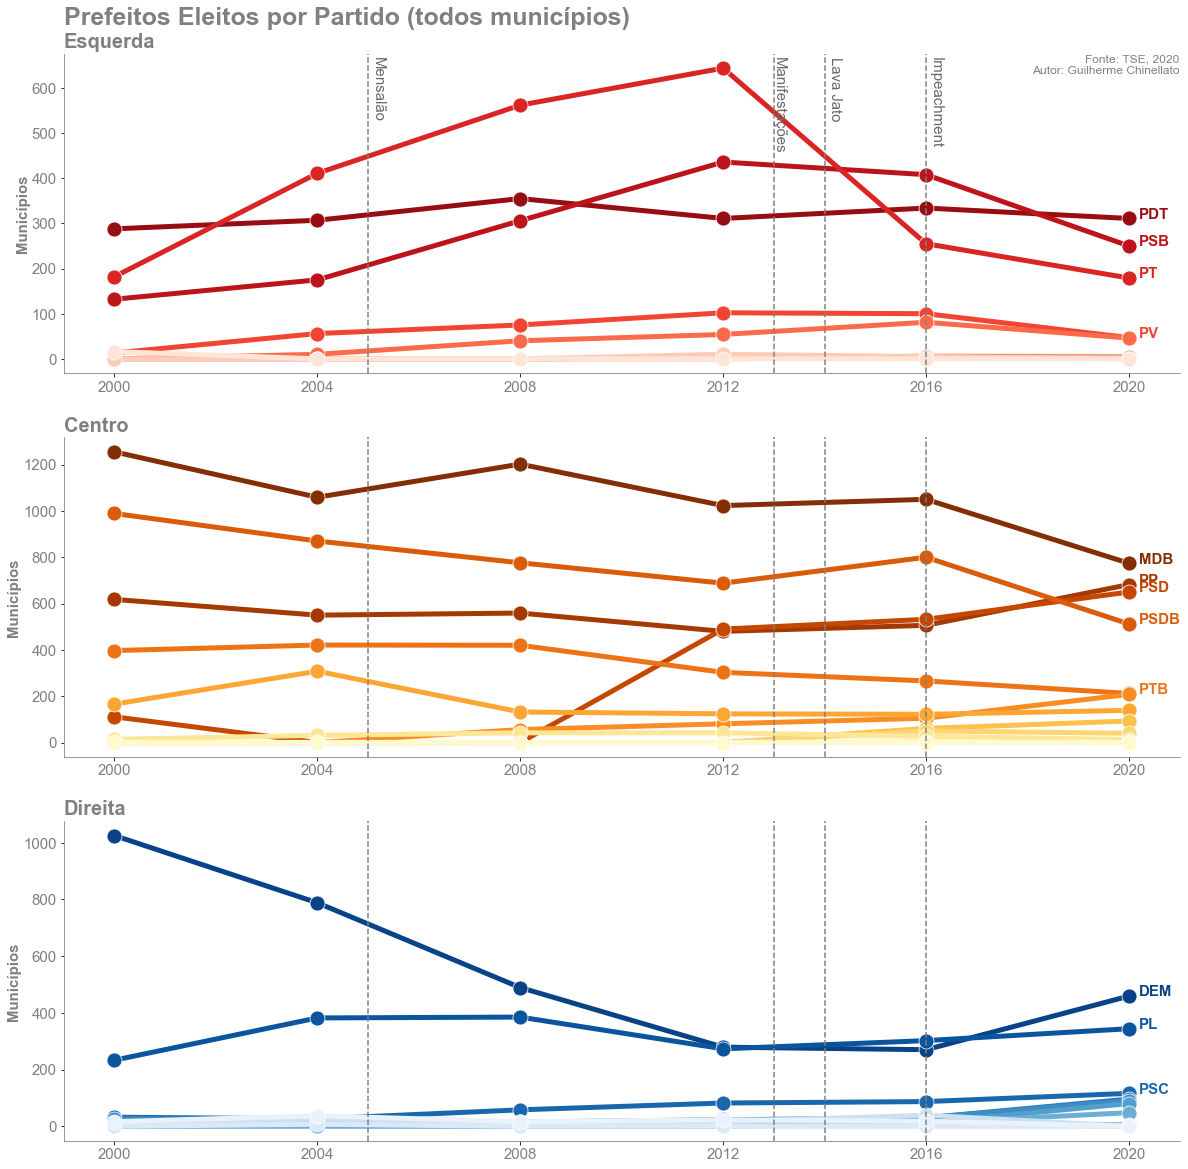

In [36]:
fig, axs = plt.subplots(3,1, figsize = (20,20))

sns.set_style('white')
sns.despine()

title = 'Prefeitos Eleitos por Partido (todos municípios)'
legend = '\n'.join((
    r'Fonte: TSE, 2020',
    r'Autor: Guilherme Chinellato'
))

plt.text(x=0.125, y=0.9, s=title, fontsize=25, color='grey', fontweight='bold',
         transform=fig.transFigure)

axs[0].text(1.0, 1.0, legend, transform=axs[0].transAxes, fontsize=12, ha='right', va='top', color='grey')

draw_subplots(axs, r_esq, r_centro, r_dir) 

plt.savefig('output/prefeitos_partido_total.png', dpi=300, bbox_inches = 'tight')

Resultado agregado

In [37]:
agg_total = pd.DataFrame(columns=['Esquerda','Centro','Direita'], index=ano_da_eleicao)
for k,v in enumerate(r_esq.index):
    agg_total.loc[v,'Esquerda'] = r_esq.loc[v].sum()

for k,v in enumerate(r_centro.index):
    agg_total.loc[v,'Centro'] = r_centro.loc[v].sum()
    
for k,v in enumerate(r_dir.index):
    agg_total.loc[v,'Direita'] = r_dir.loc[v].sum()
    
agg_total_var = agg_total.pct_change().stack().reset_index()
agg_total_var.columns = ['Ano','Ideologia', 'Variação']
    
agg_total

,Esquerda,Centro,Direita
2000,631,3551,1361
2004,959,3240,1360
2008,1338,3187,1032
2012,1559,3231,778
2016,1191,3523,833
2020,842,3324,1241


### Capitais

In [38]:
# converter estado e municipio para sem acentos e maiusculo
capitais_upper = {k.upper() : unidecode(v.upper()) for k,v in capitais.items() }

# eliminar Distrito Federal pois a capital Brasilia não possue eleiçao municipal
del capitais_upper['DF']

# eliminar municipios que possuem o mesmo nome, mas são de diferentes estados
df_temp = df.assign(nome_sigla_municipio = df.sigla_uf + ',' + df.nome_municipio)

# somente municipios das capitais
lista_capitais = [ k + ',' + v for k,v in capitais_upper.items() ]
df_capitais = df_temp[(df_temp.nome_sigla_municipio.isin(lista_capitais))]

In [39]:
res_capitais = pd.DataFrame()
res_capitais = group_by_year(df_capitais)

In [40]:
res_capitais.insert(0, 'ideologia', res_capitais.index.map(mapa_ideologico))
res_capitais.to_excel('output/flourish_prefeitos_municipios_capitais.xlsx')

Agrupar por ideologia dos partidos

In [41]:
r_esq_capitais = res_capitais[res_capitais.ideologia == 'Esquerda']
r_esq_capitais = r_esq_capitais.drop('ideologia', axis=1).T
r_esq_capitais = r_esq_capitais.fillna(0).astype(int)
r_esq_capitais.sort_values(r_esq_capitais.index[-1], axis=1, ascending=False, inplace=True)

r_centro_capitais = res_capitais[res_capitais.ideologia == 'Centro']
r_centro_capitais = r_centro_capitais.drop('ideologia', axis=1).T
r_centro_capitais = r_centro_capitais.fillna(0).astype(int)
r_centro_capitais.sort_values(r_centro_capitais.index[-1], axis=1, ascending=False, inplace=True)

r_dir_capitais = res_capitais[res_capitais.ideologia == 'Direita']
r_dir_capitais = r_dir_capitais.drop('ideologia', axis=1).T
r_dir_capitais = r_dir_capitais.fillna(0).astype(int)
r_dir_capitais.sort_values(r_dir_capitais.index[-1], axis=1, ascending=False, inplace=True)

Resultado agregado

In [42]:
agg_capitais = pd.DataFrame(columns=['Esquerda','Centro','Direita'], index=ano_da_eleicao)
for k,v in enumerate(r_esq_capitais.index):
    agg_capitais.loc[v,'Esquerda'] = r_esq_capitais.loc[v].sum()
    
for k,v in enumerate(r_centro_capitais.index):
    agg_capitais.loc[v,'Centro'] = r_centro_capitais.loc[v].sum()
    
for k,v in enumerate(r_dir_capitais.index):
    agg_capitais.loc[v,'Direita'] = r_dir_capitais.loc[v].sum()
    
agg_capitais_var = agg_capitais.pct_change().stack().reset_index()
agg_capitais_var.columns = ['Ano','Ideologia', 'Variação']
    
agg_capitais

,Esquerda,Centro,Direita
2000,6,8,2
2004,15,10,1
2008,12,13,1
2012,13,10,3
2016,8,16,2
2020,0,4,3


### Cidades Grandes: >500mil hab.

In [43]:
res_municipios_grandes = pd.DataFrame()
res_municipios_grandes = group_by_year(df[df['População'] >= 500000])

In [44]:
res_municipios_grandes.insert(0, 'ideologia', res_municipios_grandes.index.map(mapa_ideologico))
res_municipios_grandes.to_excel('output/flourish_prefeitos_municipios_grandes.xlsx')

Agrupar por ideologia dos partidos

In [45]:
r_esq_municipios_grandes = res_municipios_grandes[res_municipios_grandes.ideologia == 'Esquerda']
r_esq_municipios_grandes = r_esq_municipios_grandes.drop('ideologia', axis=1).T
r_esq_municipios_grandes = r_esq_municipios_grandes.fillna(0).astype(int)
r_esq_municipios_grandes.sort_values(r_esq_municipios_grandes.index[-1], axis=1, ascending=False, inplace=True)

r_centro_municipios_grandes = res_municipios_grandes[res_municipios_grandes.ideologia == 'Centro']
r_centro_municipios_grandes = r_centro_municipios_grandes.drop('ideologia', axis=1).T
r_centro_municipios_grandes = r_centro_municipios_grandes.fillna(0).astype(int)
r_centro_municipios_grandes.sort_values(r_centro_municipios_grandes.index[-1], axis=1, ascending=False, inplace=True)

r_dir_municipios_grandes = res_municipios_grandes[res_municipios_grandes.ideologia == 'Direita']
r_dir_municipios_grandes = r_dir_municipios_grandes.drop('ideologia', axis=1).T
r_dir_municipios_grandes = r_dir_municipios_grandes.fillna(0).astype(int)
r_dir_municipios_grandes.sort_values(r_dir_municipios_grandes.index[-1], axis=1, ascending=False, inplace=True)

Resultado agregado

In [46]:
agg_municipios_grandes = pd.DataFrame(columns=['Esquerda','Centro','Direita'], index=ano_da_eleicao)
for k,v in enumerate(r_esq_municipios_grandes.index):
    agg_municipios_grandes.loc[v,'Esquerda'] = r_esq_municipios_grandes.loc[v].sum()

for k,v in enumerate(r_centro_municipios_grandes.index):
    agg_municipios_grandes.loc[v,'Centro'] = r_centro_municipios_grandes.loc[v].sum()
    
for k,v in enumerate(r_dir_municipios_grandes.index):
    agg_municipios_grandes.loc[v,'Direita'] = r_dir_municipios_grandes.loc[v].sum()

agg_municipios_grandes_var = agg_municipios_grandes.pct_change().stack().reset_index()
agg_municipios_grandes_var.columns = ['Ano','Ideologia', 'Variação']
    
agg_municipios_grandes

,Esquerda,Centro,Direita
2000,15,19,3
2004,24,19,5
2008,19,25,4
2012,25,16,7
2016,10,31,7
2020,1,12,5


### Cidades Médias: >100mil e <500mil hab.

In [47]:
res_municipios_medios = pd.DataFrame()
res_municipios_medios = group_by_year(df[(df['População'] >= 100000) & (df['População'] < 500000)])

In [48]:
res_municipios_medios.insert(0, 'ideologia', res_municipios_medios.index.map(mapa_ideologico))
res_municipios_medios.to_excel('output/flourish_prefeitos_municipios_medios.xlsx')

Agrupar por ideologia dos partidos

In [49]:
r_esq_municipios_medios = res_municipios_medios[res_municipios_medios.ideologia == 'Esquerda']
r_esq_municipios_medios = r_esq_municipios_medios.drop('ideologia', axis=1).T
r_esq_municipios_medios = r_esq_municipios_medios.fillna(0).astype(int)
r_esq_municipios_medios.sort_values(r_esq_municipios_medios.index[-1], axis=1, ascending=False, inplace=True)

r_centro_municipios_medios = res_municipios_medios[res_municipios_medios.ideologia == 'Centro']
r_centro_municipios_medios = r_centro_municipios_medios.drop('ideologia', axis=1).T
r_centro_municipios_medios = r_centro_municipios_medios.fillna(0).astype(int)
r_centro_municipios_medios.sort_values(r_centro_municipios_medios.index[-1], axis=1, ascending=False, inplace=True)

r_dir_municipios_medios = res_municipios_medios[res_municipios_medios.ideologia == 'Direita']
r_dir_municipios_medios = r_dir_municipios_medios.drop('ideologia', axis=1).T
r_dir_municipios_medios = r_dir_municipios_medios.fillna(0).astype(int)
r_dir_municipios_medios.sort_values(r_dir_municipios_medios.index[-1], axis=1, ascending=False, inplace=True)

Resultado agregado

In [50]:
agg_municipios_medios = pd.DataFrame(columns=['Esquerda','Centro','Direita'], index=ano_da_eleicao)
for k,v in enumerate(r_esq_municipios_medios.index):
    agg_municipios_medios.loc[v,'Esquerda'] = r_esq_municipios_medios.loc[v].sum()

for k,v in enumerate(r_centro_municipios_medios.index):
    agg_municipios_medios.loc[v,'Centro'] = r_centro_municipios_medios.loc[v].sum()
    
for k,v in enumerate(r_dir_municipios_medios.index):
    agg_municipios_medios.loc[v,'Direita'] = r_dir_municipios_medios.loc[v].sum()

agg_municipios_medios_var = agg_municipios_medios.pct_change().stack().reset_index()
agg_municipios_medios_var.columns = ['Ano','Ideologia', 'Variação']
    
agg_municipios_medios

,Esquerda,Centro,Direita
2000,73,155,48
2004,76,154,47
2008,102,136,39
2012,98,159,20
2016,56,180,40
2020,28,148,63


### Cidades Pequenas: <100mil hab.

In [51]:
res_municipios_pequenos = pd.DataFrame()
res_municipios_pequenos = group_by_year(df[df['População'] < 100000])

In [52]:
res_municipios_pequenos.insert(0, 'ideologia', res_municipios_pequenos.index.map(mapa_ideologico))
res_municipios_pequenos.to_excel('output/flourish_prefeitos_municipios_pequenos.xlsx')

Agrupar por ideologia dos partidos

In [53]:
r_esq_municipios_pequenos = res_municipios_pequenos[res_municipios_pequenos.ideologia == 'Esquerda']
r_esq_municipios_pequenos = r_esq_municipios_pequenos.drop('ideologia', axis=1).T
r_esq_municipios_pequenos = r_esq_municipios_pequenos.fillna(0).astype(int)
r_esq_municipios_pequenos.sort_values(r_esq_municipios_pequenos.index[-1], axis=1, ascending=False, inplace=True)

r_centro_municipios_pequenos = res_municipios_pequenos[res_municipios_pequenos.ideologia == 'Centro']
r_centro_municipios_pequenos = r_centro_municipios_pequenos.drop('ideologia', axis=1).T
r_centro_municipios_pequenos = r_centro_municipios_pequenos.fillna(0).astype(int)
r_centro_municipios_pequenos.sort_values(r_centro_municipios_pequenos.index[-1], axis=1, ascending=False, inplace=True)

r_dir_municipios_pequenos = res_municipios_pequenos[res_municipios_pequenos.ideologia == 'Direita']
r_dir_municipios_pequenos = r_dir_municipios_pequenos.drop('ideologia', axis=1).T
r_dir_municipios_pequenos = r_dir_municipios_pequenos.fillna(0).astype(int)
r_dir_municipios_pequenos.sort_values(r_dir_municipios_pequenos.index[-1], axis=1, ascending=False, inplace=True)

Resultado agregado

In [54]:
agg_municipios_pequenos = pd.DataFrame(columns=['Esquerda','Centro','Direita'], index=ano_da_eleicao)
for k,v in enumerate(r_esq_municipios_pequenos.index):
    agg_municipios_pequenos.loc[v,'Esquerda'] = r_esq_municipios_pequenos.loc[v].sum()

for k,v in enumerate(r_centro_municipios_pequenos.index):
    agg_municipios_pequenos.loc[v,'Centro'] = r_centro_municipios_pequenos.loc[v].sum()
    
for k,v in enumerate(r_dir_municipios_pequenos.index):
    agg_municipios_pequenos.loc[v,'Direita'] = r_dir_municipios_pequenos.loc[v].sum()

agg_municipios_pequenos_var = agg_municipios_pequenos.pct_change().stack().reset_index()
agg_municipios_pequenos_var.columns = ['Ano','Ideologia', 'Variação']
    
agg_municipios_pequenos

,Esquerda,Centro,Direita
2000,543,3377,1310
2004,859,3067,1308
2008,1217,3026,989
2012,1436,3056,751
2016,1125,3312,786
2020,813,3164,1173


### Densidade Populacional

In [55]:
res_den = pd.DataFrame()
for i, val in enumerate(ano_da_eleicao):
    df_temp = df[df.ano_eleicao == val].drop_duplicates(subset='codigo_municipio', keep='first')
    df_temp = df_temp.groupby(['grupo_densidade','ideologia'])['ideologia'].count().unstack()
    df_temp.fillna(0, inplace=True)
    df_temp['year'] = val
    res_den = res_den.append(df_temp) 
    
res_den.reset_index(drop=False, inplace=True)
res_den = res_den[['year','grupo_densidade','Esquerda','Centro','Direita']]

res_den.to_excel('output/flourish_prefeitos_municipios_densidade.xlsx')

In [56]:
res_den_maior = res_den[res_den.grupo_densidade == 6].copy()
res_den_maior.drop('grupo_densidade',axis=1,inplace=True)
res_den_maior.set_index('year', inplace=True)

res_den_menor = res_den[res_den.grupo_densidade != 6].groupby('year').sum()
res_den_menor.drop('grupo_densidade',axis=1,inplace=True)

res_den_maior_var = res_den_maior.pct_change().stack().reset_index()
res_den_maior_var.columns = ['Ano','Ideologia','Variação']

res_den_menor_var = res_den_menor.pct_change().stack().reset_index()
res_den_menor_var.columns = ['Ano','Ideologia','Variação']

# Evolução de prefeitos eleitos por ideologia do partido

In [57]:
col = ['Ano','Município','Esquerda','Centro','Direita']

r = pd.DataFrame()
for i, val in enumerate(ano_da_eleicao):    
    t = pd.DataFrame(columns=col)

    t['Ano'] = [val,val,val]
    t['Município'] = ['Grandes','Médios','Pequenos']

    t.iloc[0,2] = round((agg_municipios_grandes.loc[val,'Esquerda'] / agg_municipios_grandes.loc[val].sum())*100,2)
    t.iloc[0,3] = round((agg_municipios_grandes.loc[val,'Centro'] / agg_municipios_grandes.loc[val].sum())*100,2)
    t.iloc[0,4] = round((agg_municipios_grandes.loc[val,'Direita'] / agg_municipios_grandes.loc[val].sum())*100,2)

    t.iloc[1,2] = round((agg_municipios_medios.loc[val,'Esquerda'] / agg_municipios_medios.loc[val].sum())*100,2)
    t.iloc[1,3] = round((agg_municipios_medios.loc[val,'Centro'] / agg_municipios_medios.loc[val].sum())*100,2)
    t.iloc[1,4] = round((agg_municipios_medios.loc[val,'Direita'] / agg_municipios_medios.loc[val].sum())*100,2)

    t.iloc[2,2] = round((agg_municipios_pequenos.loc[val,'Esquerda'] / agg_municipios_pequenos.loc[val].sum())*100,2)
    t.iloc[2,3] = round((agg_municipios_pequenos.loc[val,'Centro'] / agg_municipios_pequenos.loc[val].sum())*100,2)
    t.iloc[2,4] =round((agg_municipios_pequenos.loc[val,'Direita'] / agg_municipios_pequenos.loc[val].sum())*100,2)
    
    r = r.append(t)
    
r.to_excel('output/flourish_prefeitos_ideologia_perc.xlsx')
r

,Ano,Município,Esquerda,Centro,Direita
0,2000,Grandes,40.54,51.35,8.11
1,2000,Médios,26.45,56.16,17.39
2,2000,Pequenos,10.38,64.57,25.05
0,2004,Grandes,50,39.58,10.42
1,2004,Médios,27.44,55.6,16.97
2,2004,Pequenos,16.41,58.6,24.99
0,2008,Grandes,39.58,52.08,8.33
1,2008,Médios,36.82,49.1,14.08
2,2008,Pequenos,23.26,57.84,18.9
0,2012,Grandes,52.08,33.33,14.58


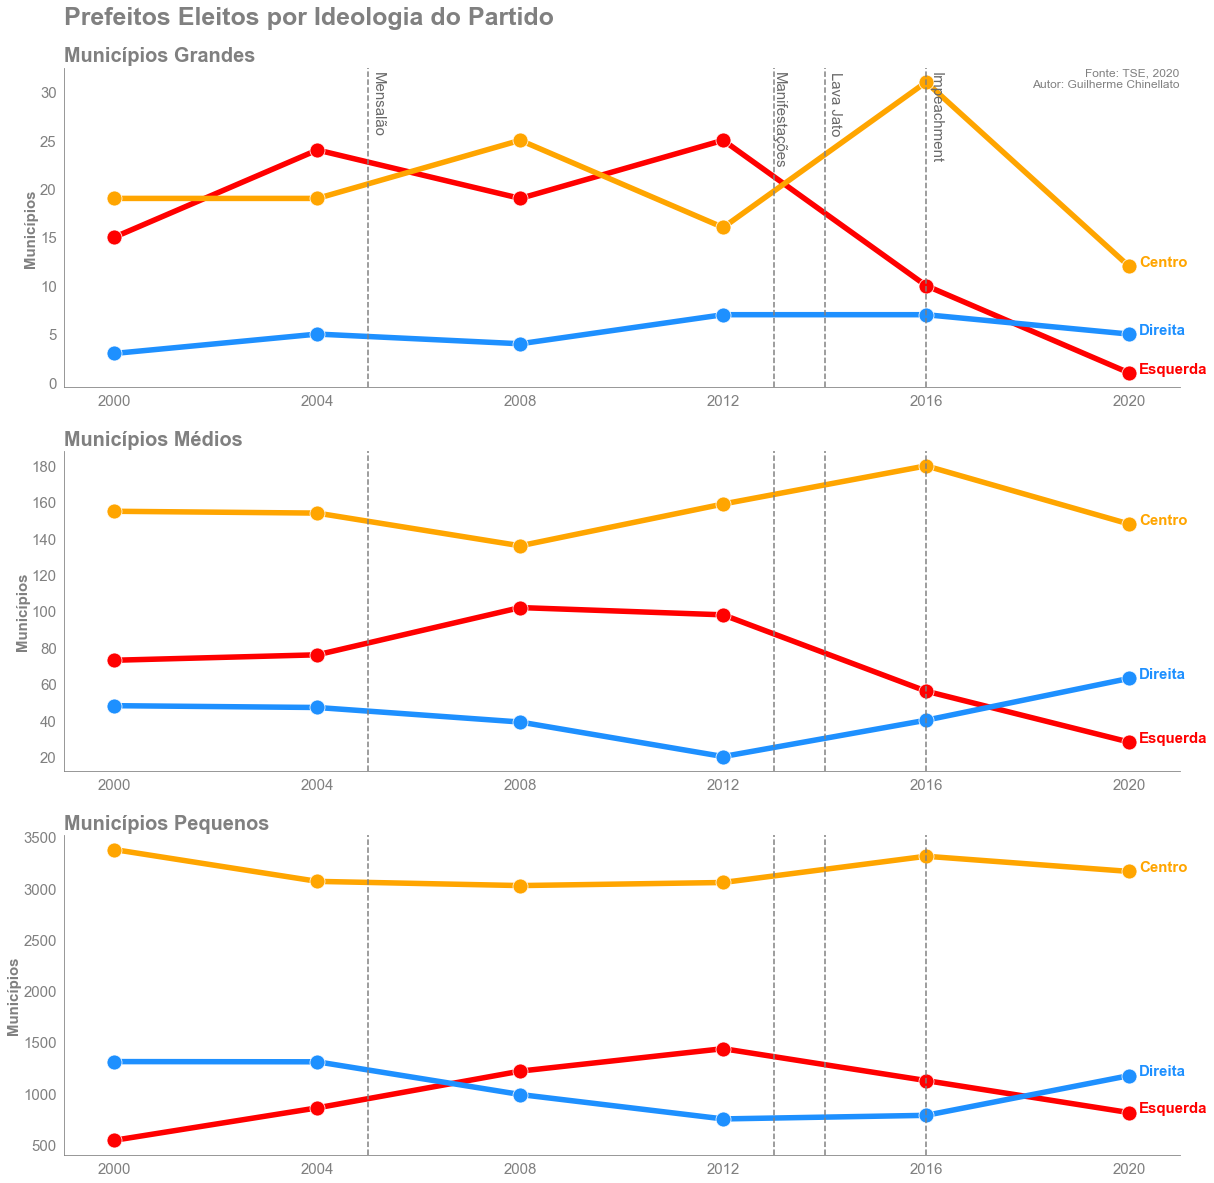

In [58]:
colors = ['red', 'orange', 'dodgerblue']

fig, axs = plt.subplots(3,1, figsize = (20,20))

sns.set_style('white')
sns.despine()

title='Prefeitos Eleitos por Ideologia do Partido'
plt.text(x=0.125, y=0.91, s=title, fontsize=25, color='grey', fontweight='bold',
         transform=fig.transFigure)

l_grande = sns.lineplot(data=agg_municipios_grandes, dashes=False, legend=False, linewidth=5.5,
                       palette=colors, marker='o', markersize=15, ax=axs[0])
l_medio = sns.lineplot(data=agg_municipios_medios, dashes=False, legend=False, linewidth=5.5,
                       palette=colors, marker='o', markersize=15, ax=axs[1])
l_pequeno = sns.lineplot(data=agg_municipios_pequenos, dashes=False, legend=False, linewidth=5.5,
                       palette=colors, marker='o', markersize=15, ax=axs[2])

axs[0].set_title('Municípios Grandes', loc='left',
                 fontsize=20, fontweight='bold', color='grey')
axs[1].set_title('Municípios Médios', loc='left',
                 fontsize=20, fontweight='bold', color='grey')
axs[2].set_title('Municípios Pequenos', loc='left',
                 fontsize=20, fontweight='bold', color='grey')

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')

axs[0].set_ylabel('Municípios', labelpad=2, fontsize=15, fontweight='bold', color='grey')
axs[1].set_ylabel('Municípios', labelpad=2, fontsize=15, fontweight='bold', color='grey')
axs[2].set_ylabel('Municípios', labelpad=2, fontsize=15, fontweight='bold', color='grey')

axs[0].set_xticks(np.arange(ano_da_eleicao[0], ano_da_eleicao[-1]+2, step=4))
axs[1].set_xticks(np.arange(ano_da_eleicao[0], ano_da_eleicao[-1]+2, step=4))
axs[2].set_xticks(np.arange(ano_da_eleicao[0], ano_da_eleicao[-1]+2, step=4))

axs[0].set_xticklabels(labels=[int(i) for i in axs[0].get_xticks()], fontsize=15, color='grey')
axs[1].set_xticklabels(labels=[int(i) for i in axs[1].get_xticks()], fontsize=15, color='grey')
axs[2].set_xticklabels(labels=[int(i) for i in axs[2].get_xticks()], fontsize=15, color='grey')

axs[0].set_yticklabels(labels=[int(i) for i in axs[0].get_yticks()], fontsize=15, color='grey')
axs[1].set_yticklabels(labels=[int(i) for i in axs[1].get_yticks()], fontsize=15, color='grey')
axs[2].set_yticklabels(labels=[int(i) for i in axs[2].get_yticks()], fontsize=15, color='grey')

axs[0].spines['bottom'].set_color('grey')
axs[0].spines['left'].set_color('grey')
axs[1].spines['bottom'].set_color('grey')
axs[1].spines['left'].set_color('grey') 
axs[2].spines['bottom'].set_color('grey')
axs[2].spines['left'].set_color('grey') 

#def flip(items, ncol):
#    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

#handles, labels = axs[0].get_legend_handles_labels()
#leg = l_grande.legend(flip(handles, 4), flip(labels, 4), loc=2, ncol=4, fontsize=15, borderaxespad=0.)    
#for line in leg.get_lines():
#    line.set_linewidth(5.5)

axs[0].text(1.0, 1.0, legend, transform=axs[0].transAxes, fontsize=12, ha='right', va='top', color='grey')

for i in range(len(axs[0].get_lines())):
    axs[0].text(agg_municipios_grandes.index[-1]+.2, agg_municipios_grandes.iloc[-1,i], agg_municipios_grandes.columns[i],
                fontsize=15, fontweight='bold', color=axs[0].get_lines()[i].get_color())

for i in range(len(axs[1].get_lines())):
    axs[1].text(agg_municipios_medios.index[-1]+.2, agg_municipios_medios.iloc[-1,i], agg_municipios_medios.columns[i],
                fontsize=15, fontweight='bold', color=axs[1].get_lines()[i].get_color())

for i in range(len(axs[2].get_lines())):
    axs[2].text(agg_municipios_pequenos.index[-1]+.2, agg_municipios_pequenos.iloc[-1,i], agg_municipios_pequenos.columns[i],
                fontsize=15, fontweight='bold', color=axs[2].get_lines()[i].get_color())

axs[0].axvline(2005, color='grey', linestyle='--')
axs[0].axvline(2013, color='grey', linestyle='--')
axs[0].axvline(2014, color='grey', linestyle='--')
axs[0].axvline(2016, color='grey', linestyle='--')

axs[1].axvline(2005, color='grey', linestyle='--')
axs[1].axvline(2013, color='grey', linestyle='--')
axs[1].axvline(2014, color='grey', linestyle='--')
axs[1].axvline(2016, color='grey', linestyle='--')

axs[2].axvline(2005, color='grey', linestyle='--')
axs[2].axvline(2013, color='grey', linestyle='--')
axs[2].axvline(2014, color='grey', linestyle='--')
axs[2].axvline(2016, color='grey', linestyle='--')

axs[0].text(0.275, 0.99, 'Mensalão', transform=axs[0].transAxes, rotation=-90,
            fontsize=15, color='dimgrey', verticalalignment='top')
axs[0].text(0.635, 0.99, 'Manifestações', transform=axs[0].transAxes, rotation=-90,
            fontsize=15, color='dimgrey', verticalalignment='top')
axs[0].text(0.685, 0.99, 'Lava Jato', transform=axs[0].transAxes, rotation=-90,
            fontsize=15, color='dimgrey', verticalalignment='top')
axs[0].text(0.775, 0.99, 'Impeachment', transform=axs[0].transAxes, rotation=-90,
            fontsize=15, color='dimgrey', verticalalignment='top')

plt.savefig('output/prefeitos_ideologia.png', dpi=300, bbox_inches = 'tight')

Variação entre eleições

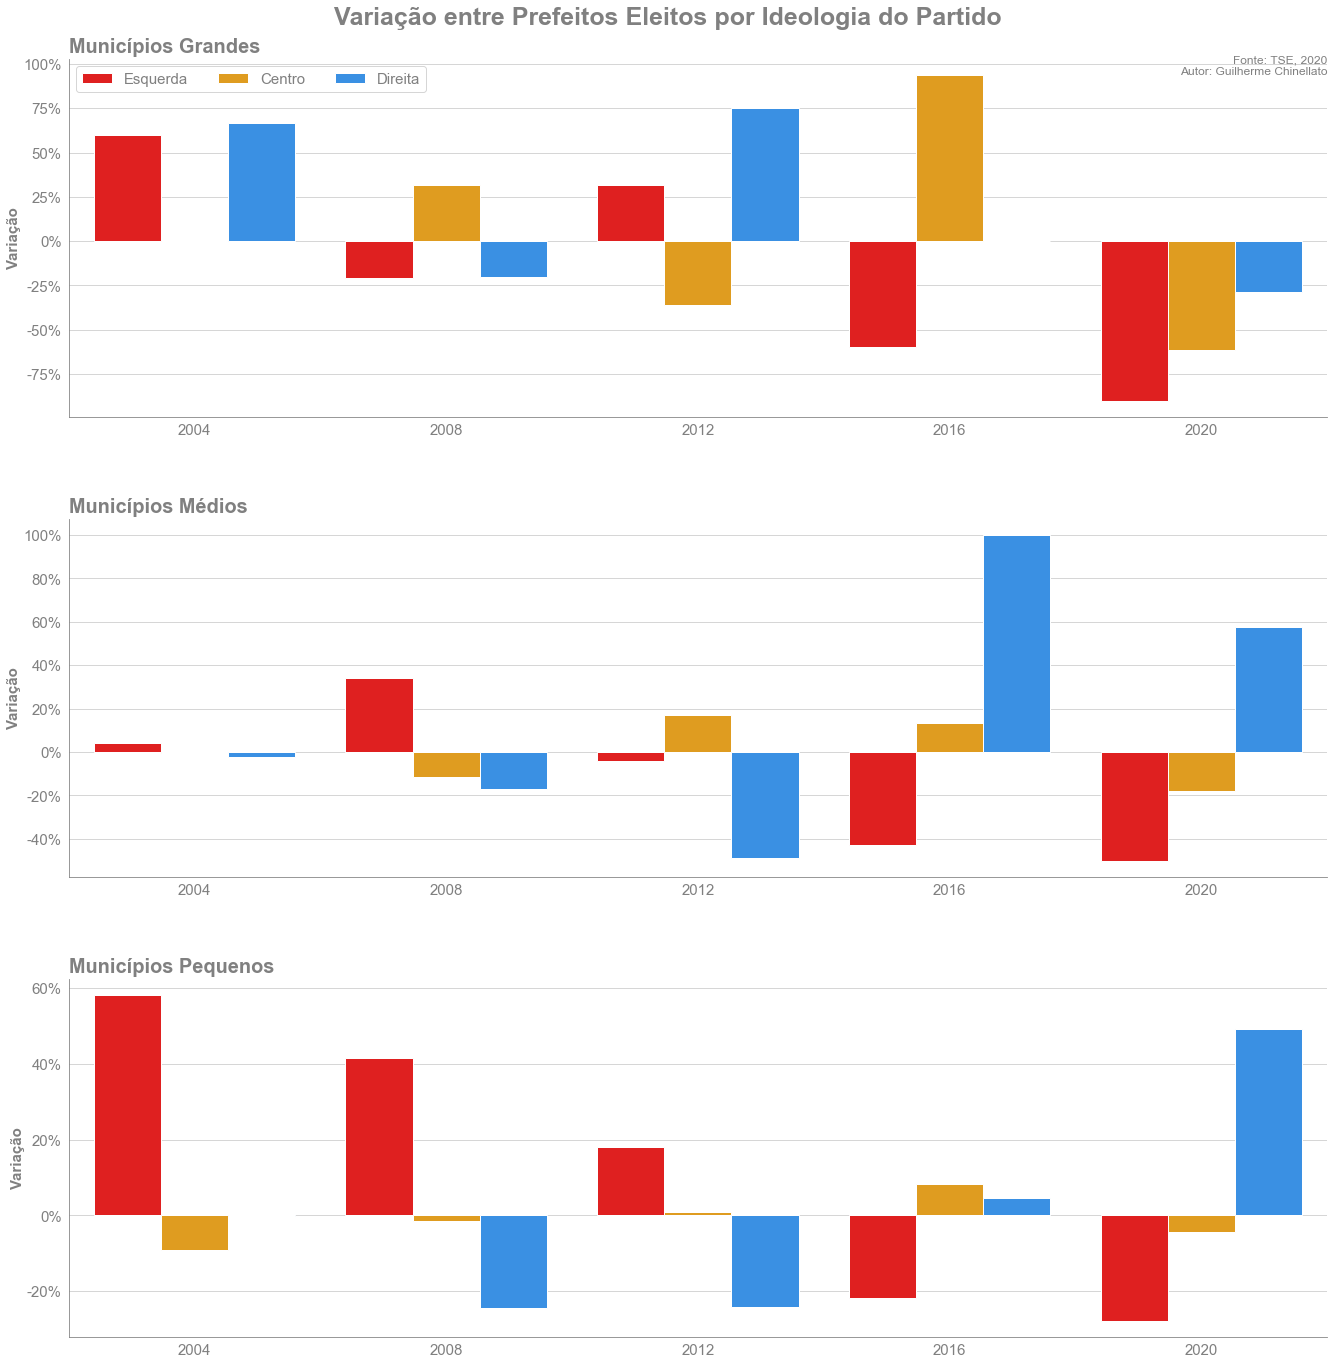

In [70]:
fig, axs = plt.subplots(3,1, figsize = (20,20))

sns.set_style('whitegrid')
sns.despine()

c_grande = sns.catplot(data=agg_municipios_grandes_var, x='Ano', y='Variação', hue='Ideologia', kind='bar',
                      palette=colors, ax=axs[0])
c_medio = sns.catplot(data=agg_municipios_medios_var, x='Ano', y='Variação', hue='Ideologia', kind='bar'
                      , palette=colors, ax=axs[1])
c_pequeno = sns.catplot(data=agg_municipios_pequenos_var, x='Ano', y='Variação', hue='Ideologia', kind='bar'
                      , palette=colors, ax=axs[2])

fig.suptitle('Variação entre Prefeitos Eleitos por Ideologia do Partido', fontsize=25, fontweight='bold',
             color='grey')

axs[0].set_title('Municípios Grandes', loc='left', fontsize=20, fontweight='bold', color='grey')
axs[1].set_title('Municípios Médios', loc='left', fontsize=20, fontweight='bold', color='grey')
axs[2].set_title('Municípios Pequenos', loc='left', fontsize=20, fontweight='bold', color='grey')

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')

axs[0].set_ylabel('Variação', labelpad=2, fontsize=15, fontweight='bold', color='grey')
axs[1].set_ylabel('Variação', labelpad=2, fontsize=15, fontweight='bold', color='grey')
axs[2].set_ylabel('Variação', labelpad=2, fontsize=15, fontweight='bold', color='grey')

axs[0].set_xticklabels(labels=[ano_da_eleicao[i+1] for i in axs[0].get_xticks()], fontsize=15, color='grey')
axs[1].set_xticklabels(labels=[ano_da_eleicao[i+1] for i in axs[1].get_xticks()], fontsize=15, color='grey')
axs[2].set_xticklabels(labels=[ano_da_eleicao[i+1] for i in axs[2].get_xticks()], fontsize=15, color='grey')

vals = axs[0].get_yticks()
axs[0].set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=15, color='grey')
vals = axs[1].get_yticks()
axs[1].set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=15, color='grey')
vals = axs[2].get_yticks()
axs[2].set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=15, color='grey')

axs[0].spines['bottom'].set_color('grey')
axs[0].spines['left'].set_color('grey')
axs[1].spines['bottom'].set_color('grey')
axs[1].spines['left'].set_color('grey')
axs[2].spines['bottom'].set_color('grey')
axs[2].spines['left'].set_color('grey') 

l = axs[0].legend(loc='upper left', ncol=4, fontsize=15)
for text in l.get_texts():
    text.set_color('grey')
axs[1].get_legend().remove()
axs[2].get_legend().remove()

axs[0].text(1.0, 1.01, legend, transform=axs[0].transAxes, fontsize=12, ha='right', va='top', color='grey')

plt.close(2)
plt.close(3)
plt.close(4)
fig.tight_layout(pad=6)
plt.savefig('output/prefeitos_ideologia_var.png', dpi=300, bbox_inches = 'tight')

Correlação entre:
- Maiores Municípios vs Menores Municípios
- Maiores Municípios vs Capitais
- Menores Municípios vs Capitais

In [60]:
corr = pd.DataFrame()
corr['Grandes/Médios'] = agg_municipios_grandes.corrwith(agg_municipios_medios, axis=0)
corr['Grandes/Pequenos'] = agg_municipios_grandes.corrwith(agg_municipios_pequenos, axis=0)
corr['Médios/Pequenos'] = agg_municipios_medios.corrwith(agg_municipios_pequenos, axis=0)

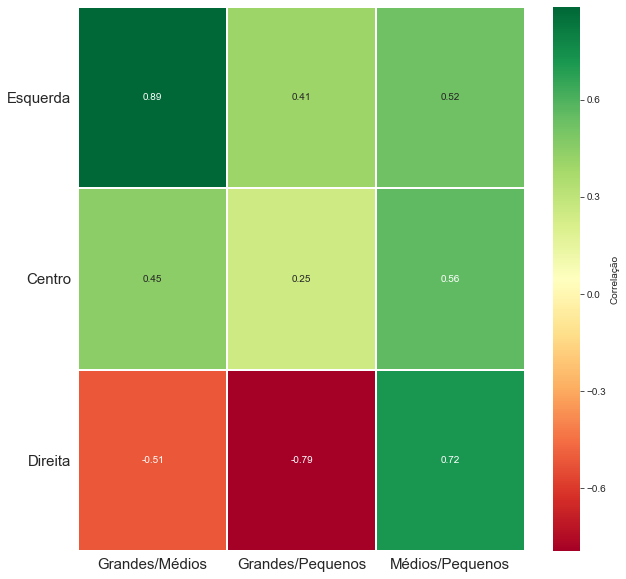

In [61]:
fig, ax = plt.subplots( figsize = (10,10))

hm = sns.heatmap(corr, cmap='RdYlGn', ax=ax, linewidths=1,
                 cbar_kws={'label': 'Correlação', 'orientation': 'vertical'},
                 annot=True, xticklabels=True, yticklabels=True)

ax.set_ylabel('')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

hm.set_xticklabels(hm.get_xticklabels(), rotation=0, fontsize=15)
hm.set_yticklabels(hm.get_yticklabels(), rotation=0, fontsize=15)
plt.savefig('output/prefeitos_correl.png', dpi=300, bbox_inches = 'tight')

In [62]:
df_merge = pd.merge(agg_municipios_grandes.stack().reset_index(), agg_municipios_medios.stack().reset_index(), how='left', on=['level_0', 'level_1'])
temp = agg_municipios_pequenos.stack().reset_index()
df_merge = pd.merge(df_merge, temp, how='left', on=['level_0', 'level_1'])
df_merge.columns = ['Ano','Ideologia','Municípios Grandes','Municípios Médios','Municípios Pequenos']

C:\Users\guilh\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


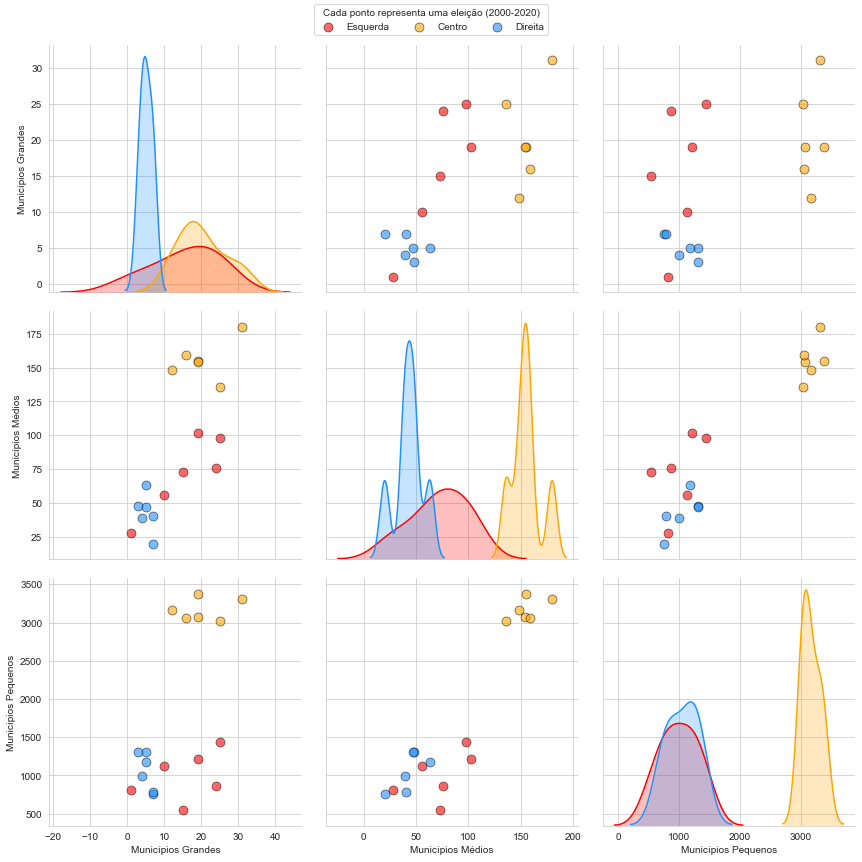

In [63]:
pp = sns.pairplot(df_merge.drop('Ano',axis=1), hue='Ideologia', kind='scatter', size=4, palette=colors,
                  plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})

pp._legend.remove()
handles = pp._legend_data.values()
labels = pp._legend_data.keys()
pp.fig.legend(handles=handles, labels=labels, title='Cada ponto representa uma eleição (2000-2020)',
              loc='upper center', ncol=4)
pp.fig.subplots_adjust(top=0.95)

plt.savefig('output/prefeitos_pairplot.png', dpi=300, bbox_inches = 'tight')

# Mapa Brasil

In [118]:
year=2016

In [119]:
df_temp = df[df.ano_eleicao == year].drop_duplicates(subset='codigo_municipio', keep='first')
df_temp.drop(['ano_eleicao','codigo_municipio','sigla_uf','nome_partido','numero_partido',
             'sigla_partido','numero_urna','total_votos','GEOCOD_IBGE','COD_TSE','AJUSTE',
             'grupo_densidade'], axis=1, inplace=True)
df_temp = df_temp[['nome_municipio','ideologia','latitude','longitude','População','densidade']]

In [120]:
df_temp.to_excel('output/flourish_prefeitos_mapa_populacao_'+str(year)+'.xlsx')

Municipios Grandes que cada ideologia possui maioria

In [121]:
df_temp.sort_values('População', ascending=False, inplace=True)

In [126]:
df_temp[(df_temp['População'] > 500000)].head(10)

,nome_municipio,ideologia,latitude,longitude,População,densidade
3550308,SAO PAULO,Centro,-23.53290,-46.6395,12325232,8102.788096
3304557,RIO DE JANEIRO,Centro,-22.91290,-43.2003,6747815,5621.637901
2927408,SALVADOR,Direita,-12.97180,-38.5011,2886698,4162.788250
2304400,FORTALEZA,Esquerda,-3.71664,-38.5423,2686612,8601.204407
3106200,BELO HORIZONTE,Direita,-19.91020,-43.9266,2521564,7609.879464
1302603,MANAUS,Centro,-3.11866,-60.0212,2219580,194.681352
4106902,CURITIBA,Centro,-25.41950,-49.2646,1948626,4480.712453
2611606,RECIFE,Esquerda,-8.04666,-34.8771,1653461,7555.466704
5208707,GOIANIA,Centro,-16.68640,-49.2643,1536097,2107.588624
1501402,BELEM,Centro,-1.45540,-48.4898,1499641,1415.468736


In [123]:
df_temp[(df_temp['População'] > 500000) & (df_temp.ideologia == 'Esquerda')].head()

,nome_municipio,ideologia,latitude,longitude,População,densidade
2304400,FORTALEZA,Esquerda,-3.71664,-38.5423,2686612,8601.204407
2611606,RECIFE,Esquerda,-8.04666,-34.8771,1653461,7555.466704
3518800,GUARULHOS,Esquerda,-23.45380,-46.5333,1392121,4368.466306
3509502,CAMPINAS,Esquerda,-22.90530,-47.0659,1213792,1527.606721
2111300,SAO LUIS,Esquerda,-2.53874,-44.2825,1108975,1902.271799


In [124]:
df_temp[(df_temp['População'] > 500000) & (df_temp.ideologia == 'Centro')].head()

,nome_municipio,ideologia,latitude,longitude,População,densidade
3550308,SAO PAULO,Centro,-23.53290,-46.6395,12325232,8102.788096
3304557,RIO DE JANEIRO,Centro,-22.91290,-43.2003,6747815,5621.637901
1302603,MANAUS,Centro,-3.11866,-60.0212,2219580,194.681352
4106902,CURITIBA,Centro,-25.41950,-49.2646,1948626,4480.712453
5208707,GOIANIA,Centro,-16.68640,-49.2643,1536097,2107.588624


In [125]:
df_temp[(df_temp['População'] > 500000) & (df_temp.ideologia == 'Direita')].head()

,nome_municipio,ideologia,latitude,longitude,População,densidade
2927408,SALVADOR,Direita,-12.97180,-38.5011,2886698,4162.788250
3106200,BELO HORIZONTE,Direita,-19.91020,-43.9266,2521564,7609.879464
3303500,NOVA IGUACU,Direita,-22.75560,-43.4603,823302,1581.506048
2607901,JABOATAO DOS GUARARAPES,Direita,-8.11298,-35.0150,706867,2732.127673
3534401,OSASCO,Direita,-23.53240,-46.7916,699944,10775.995320


Mapa do Brasil com quantidade de prefeitos eleitos com determinada ideologia do partido

In [71]:
df_novo = df.copy()
df_novo = df_novo[df_novo.ano_eleicao == year].drop_duplicates(subset='codigo_municipio', keep='first')
df_novo['CD_GEOCMU'] = df_novo['GEOCOD_IBGE'].astype(str)

df_novo.drop(['ano_eleicao','codigo_municipio','nome_partido','numero_partido',
             'sigla_partido','numero_urna','total_votos','GEOCOD_IBGE','COD_TSE','AJUSTE',
             'grupo_densidade'], axis=1, inplace=True)

In [72]:
df_mapa = gpd.read_file('input/geo/br_municipios/BRMUE250GC_SIR.shp')
df_mapa['NM_MUNICIP'] = df_mapa['NM_MUNICIP'].str.upper().apply(lambda x: unidecode(x))

df_mapa_novo = pd.merge(df_mapa, df_novo, how='left', on='CD_GEOCMU')
df_mapa_novo.set_index('CD_GEOCMU', inplace=True)
df_mapa_novo.dropna(inplace=True)

In [76]:
df_mapa_uf = gpd.read_file('input/geo/br_unidades_da_federacao/BR_UF_2019.shp')

df_novo_uf = df_novo.groupby(['sigla_uf','ideologia'])['CD_GEOCMU'].count().unstack().reset_index()
df_novo_uf['max'] = df_novo_uf[['Centro','Direita','Esquerda']].idxmax(axis=1)

df_mapa_uf_novo = pd.merge(df_mapa_uf, df_novo_uf, left_on='SIGLA_UF', right_on='sigla_uf')
df_mapa_uf_novo.dropna(inplace=True)

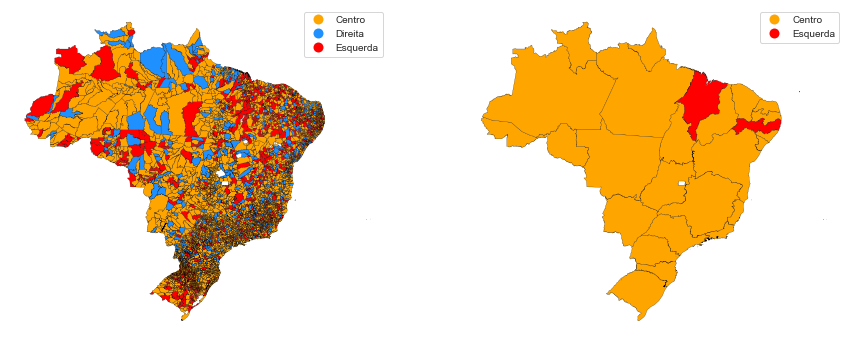

In [78]:
fig, axs = plt.subplots(1,2,figsize=(15,15))

p1 = df_mapa_novo.plot(column='ideologia', cmap=ListedColormap(['orange','dodgerblue','red']), legend=True, linewidth=0.2, ax=axs[0], edgecolor='black')
p2 = df_mapa_uf_novo.plot(column='max', cmap=ListedColormap(['orange','red']), legend=True, linewidth=0.2, ax=axs[1], edgecolor='black')

p1.set_axis_off()
p2.set_axis_off()

fig.savefig('output/prefeitos_brasil_municipios_'+str(year)+'.png', dpi=300, bbox_inches = 'tight')